<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Detect and Measure Sources in a Custom Coadded Image</b> <br>
Contact author: Melissa Graham, Aaron Meisner <br>
Last verified to run: 2024-10-21 <br>
LSST Science Pipelines version: <b>Weekly 2022_40</b> <br>
Container Size: large <br>
Targeted learning level: advanced <br>

___

**WARNING:
This notebook will only run with LSST Science Pipelines version Weekly 2022_40.**

To find out which version of the LSST Science Pipelines is being used, look in the footer bar or execute the cell below.

In [ ]:
! echo $IMAGE_DESCRIPTION

If `Weekly 2022_40` is being used, then proceed with executing the tutorial.

If `Weekly 2022_40` is **not** being used, **log out and start a new server**:
 1. At top left in the menu bar choose File then Save All and Exit.
 2. Re-enter the Notebook Aspect.
 3. At <a href="https://dp0-2.lsst.io/data-access-analysis-tools/nb-intro.html#how-to-log-in-navigate-and-log-out-of-jupyterlab">the "Server Options" stage</a>, under "Select uncached image (slower start)" choose `Weekly 2022_40`.
 4. Note that it might take a few minutes to start the server with an old image.

___


**NOTICE:
This notebook will only run with the butler repo alias `dp02-direct`.**

All other tutorial notebooks in this repository use the `dp02` alias, which was updated in Oct 2024 to provide
read-only access to butler data repos.
As this tutorial writes processed images back to the butler, "direct access" is needed and `dp02-direct` must be used.
Note that this is a temporary work around for Data Preview 0. 
Butler functionality for Data Preview 1 will be different, as the butler service continues to evolve.

___

<br><br><br><br>

**Description:** Detect and measure sources in a custom "deepCoadd" image.

**Skills:** Use the butler and LSST pipeline tasks on user-generated collections. Run source detection, deblending, and measurement.

**LSST Data Products:** user-generated deepCoadd; DP0.2 deepCoadd image and Object table

**Packages:** lsst.afw, lsst.pipe, lsst.ctrl

**Credit:** Originally developed by Melissa Graham and Clare Saunders, this tutorial draws on the contents of the "Introduction to Source Detection" DP0.2 tutorial notebook by Douglas Tucker and Alex Drlica-Wagner.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.


> **WARNING: This tutorial uses the output of notebook DP02_09a_Custom_Coadd.ipynb. Users must run that notebook first, or have already generated the relevant custom coadd from the command line as in <a href="https://dp0-2.lsst.io/tutorials-examples/cmdline-custom-coadd.html">DP0.2 command line tutorial 02</a>.**


# 1. Introduction

This tutorial notebook is a follow-up to DP02_09a_Custom_Coadd.ipynb, and demonstrates how to run source detection and measurement on a user-generated custom `deepCoadd` image.

Recall that although that new custom `deepCoadd` is not actually deep, but a rather shallower custom coadd, it will still be called `deepCoadd` in the butler because that is the default name of results from the `assembleCoadd` task.

## 1.1. Package imports

In [ ]:
import getpass
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.afw.display as afwDisplay

from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

## 1.2. Define functions and parameters

Set `afwDisplay` to use a `matplotlib` backend.

In [ ]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service, which is used in Section 3.3.

In [ ]:
tap_service = get_tap_service()

## 1.3. Find the desired coadd in the butler

Create a temporary butler in order to identify the collection and run containing the custom `deepCoadd`.

In [ ]:
my_username = getpass.getuser()
butler_repo = 'dp02-direct'

In [ ]:
tempButler = Butler(butler_repo)

Print all collections and runs associated with the current user's username.

In [ ]:
for c in sorted(tempButler.registry.queryCollections('*'+my_username+'*')):
    print(c)

Delete this temporary butler.

In [ ]:
del tempButler

Create a new butler with the collection containing the custom `deepCoadd`.

> **Stop!** Make sure the name of the collection below matches the name of the collection created when running tutorial notebook DP02_09a_Custom_Coadd.ipynb, or when executing <a href="https://dp0-2.lsst.io/tutorials-examples/cmdline-custom-coadd.html">DP0.2 command line tutorial 02</a>.

In [ ]:
inputCollection = "u/"+my_username+"/custom_coadd_window1_test1"
print(inputCollection)

In [ ]:
butler = Butler(butler_repo, collections=[inputCollection])

Use the `dataId` from tutorial notebook DP02_09a_Custom_Coadd.ipynb and retrieve the custom `deepCoadd`.

In [ ]:
my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
my_deepCoadd = butler.get('deepCoadd', my_dataId)

Confirm that the retrieved `deepCoadd` is the custom user-generated 6-input visits version.

In [ ]:
my_deepCoadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()
my_deepCoadd_inputs.visits.asAstropy()

# 2. Run source detection, deblending, and measurement

This tutorial uses an approach to running source detection that is meant to parallel the approach adopted in tutorial notebook 09a for coaddition: use the <a href="https://pipelines.lsst.io/py-api/lsst.ctrl.mpexec.SimplePipelineExecutor.html">Simple Pipeline Executor</a> to run a subset of Tasks from the DP0.2 Data Release Production (DRP) pipeline. The usage of SimplePiplineExecutor here also closely parallels the command line version of source detection demonstrated in DP0.2 <a href="https://dp0-2.lsst.io/tutorials-examples/cmdline-custom-coadd.html">command line tutorial 02</a>.

## 2.1. Set up an output collection for the source detection results

<a href="https://community.lsst.org/t/adding-new-data-to-a-butler-gen3-decam/7728/2">For technical reasons</a>, it's necessary to use a collection other than the input collection for the source detection outputs. Define an output collection name into which the custom coadd source detection results will be persisted:

In [ ]:
my_outputCollection_identifier = 'custom_coadd_window1_test1_nbdet'
my_outputCollection = 'u/' + my_username + '/'+ my_outputCollection_identifier
print(my_outputCollection)

As in the DP0.2 custom coaddition tutorial, the next step is to define a "simple butler" object that will be needed for running the SimplePipelineExecutor:

In [ ]:
simpleButler = SimplePipelineExecutor.prep_butler(butler_repo, 
                                                  inputs=[inputCollection], 
                                                  output=my_outputCollection)

Below, check that the newly created output collection is first in the list.

> **Notice:** A run timestamp has been added to `my_outputCollection` as additional information for users.

> **Warning:** To run custom coadd source detection multiple times, identify each source detection deployment with a new output collection name, such as `custom_coadd_window1_test1_nbdet2` or `custom_coadd_window1_test1_nbdet3`, and so on. <br>
Note that re-executing Section 2.4 with the _same output collection name_ will produce results with a new run timestamp, but the butler always retrieves data _from the most recent timestamp for a given collection_. Not setting a new output collection name for a new deployment of source detection is essentially like "overwriting" results in the butler. It is not recommended to work that way, but to bookkeep using output collection names.

In [ ]:
simpleButler.registry.getCollectionChain(my_outputCollection)

## 2.2. Define the source detection pipeline

Now for the pipeline definition. Use a subset of the pipeline Tasks from the DP0.2 DRP pipline, which is defined by the `$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml` YAML file. Specifically, four "steps" from within the DP0.2 DRP pipeline will be run: (1) `detection`, the initial detection of sources within the custom coadd (2) `mergeDetection`, which is needed to make possible downstream processing steps (3) `deblend`, deblending based on further analysis of the initial `detection` list (4) `measure`, which computes useful quantities, such as the photometric fluxes, given the deblended list of sources.

As in DP0.2 notebook tutorial 09a, it's necessary to combine this information about the pipeline definition YAML file name and the desired subset of pipeline steps. This is done by creating a Uniform Resource Identifier (URI) containing all of this relevant information as follows:

In [ ]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml'
steps = 'detection,mergeDetections,deblend,measure'
my_uri = yaml_file + '#' + steps
print(my_uri)

Note how the URI begins with the full DP0.2 DRP YAML pipeline definition file name, then, after a `#` character, continues with a comma-separated list of the desired pipeline steps. The order in which these steps are listed after the `#` character does not matter, though here they are listed in the order they run during processing for the sake of understandability.

Now create a source detection pipeline object based on the URI just constructed:

In [ ]:
sourceDetectionPipeline = Pipeline.from_uri(my_uri)

As in DP0.2 tutorial notebook 09a, it's necessary to apply a small number of configuration overrides to customize the pipeline's operation. The first two configuration overrides below set the detection threshold applied to the custom i-band coadd to be 10 sigma. The 10 sigma detection threshold employed here is used only for the sake of an additional configuration override example, but should not be interpreted as a general-purpose recommendation. The `multibandDeblend.maxIter` configuration override sets the maximum deblending iterations to a lower value than its default, which is a recommended mechanism for speeding up the processing. The `doPropagateFlags` configuration override is set because this processing does not need to propagate flag information about which sources were used for PSF construction.

In [ ]:
sourceDetectionPipeline.addConfigOverride('detection', 'detection.thresholdValue', 10.0)
sourceDetectionPipeline.addConfigOverride('detection', 'detection.thresholdType', "stdev")
sourceDetectionPipeline.addConfigOverride('deblend', 'multibandDeblend.maxIter', 20)
sourceDetectionPipeline.addConfigOverride('measure', 'doPropagateFlags', False)

## 2.3. The `QuantumGraph`

Recall that the `QuantumGraph` is <a href="https://pipelines.lsst.io/py-api/lsst.pipe.base.QuantumGraph.html#lsst.pipe.base.QuantumGraph">a tool</a> used by the LSST Science Pipelines to break a large processing into relatively “bite-sized” quanta and arrange these quanta into a sequence such that all inputs needed by a given quantum are available for the execution of that quantum. In the present case, the processing is not especially large, but for production deployments it makes sense to inspect and validate the `QuantumGraph` before proceeding straight to full-scale processing launch. The image below provides a visualization of the custom coadd processing's `QuantumGraph`.

Here's what the `QuantumGraph` for the pipeline to perform source detection, debleding, and measurement looks like:

<div style="max-width:1500px;margin-right: auto; margin-right: 0;">
    
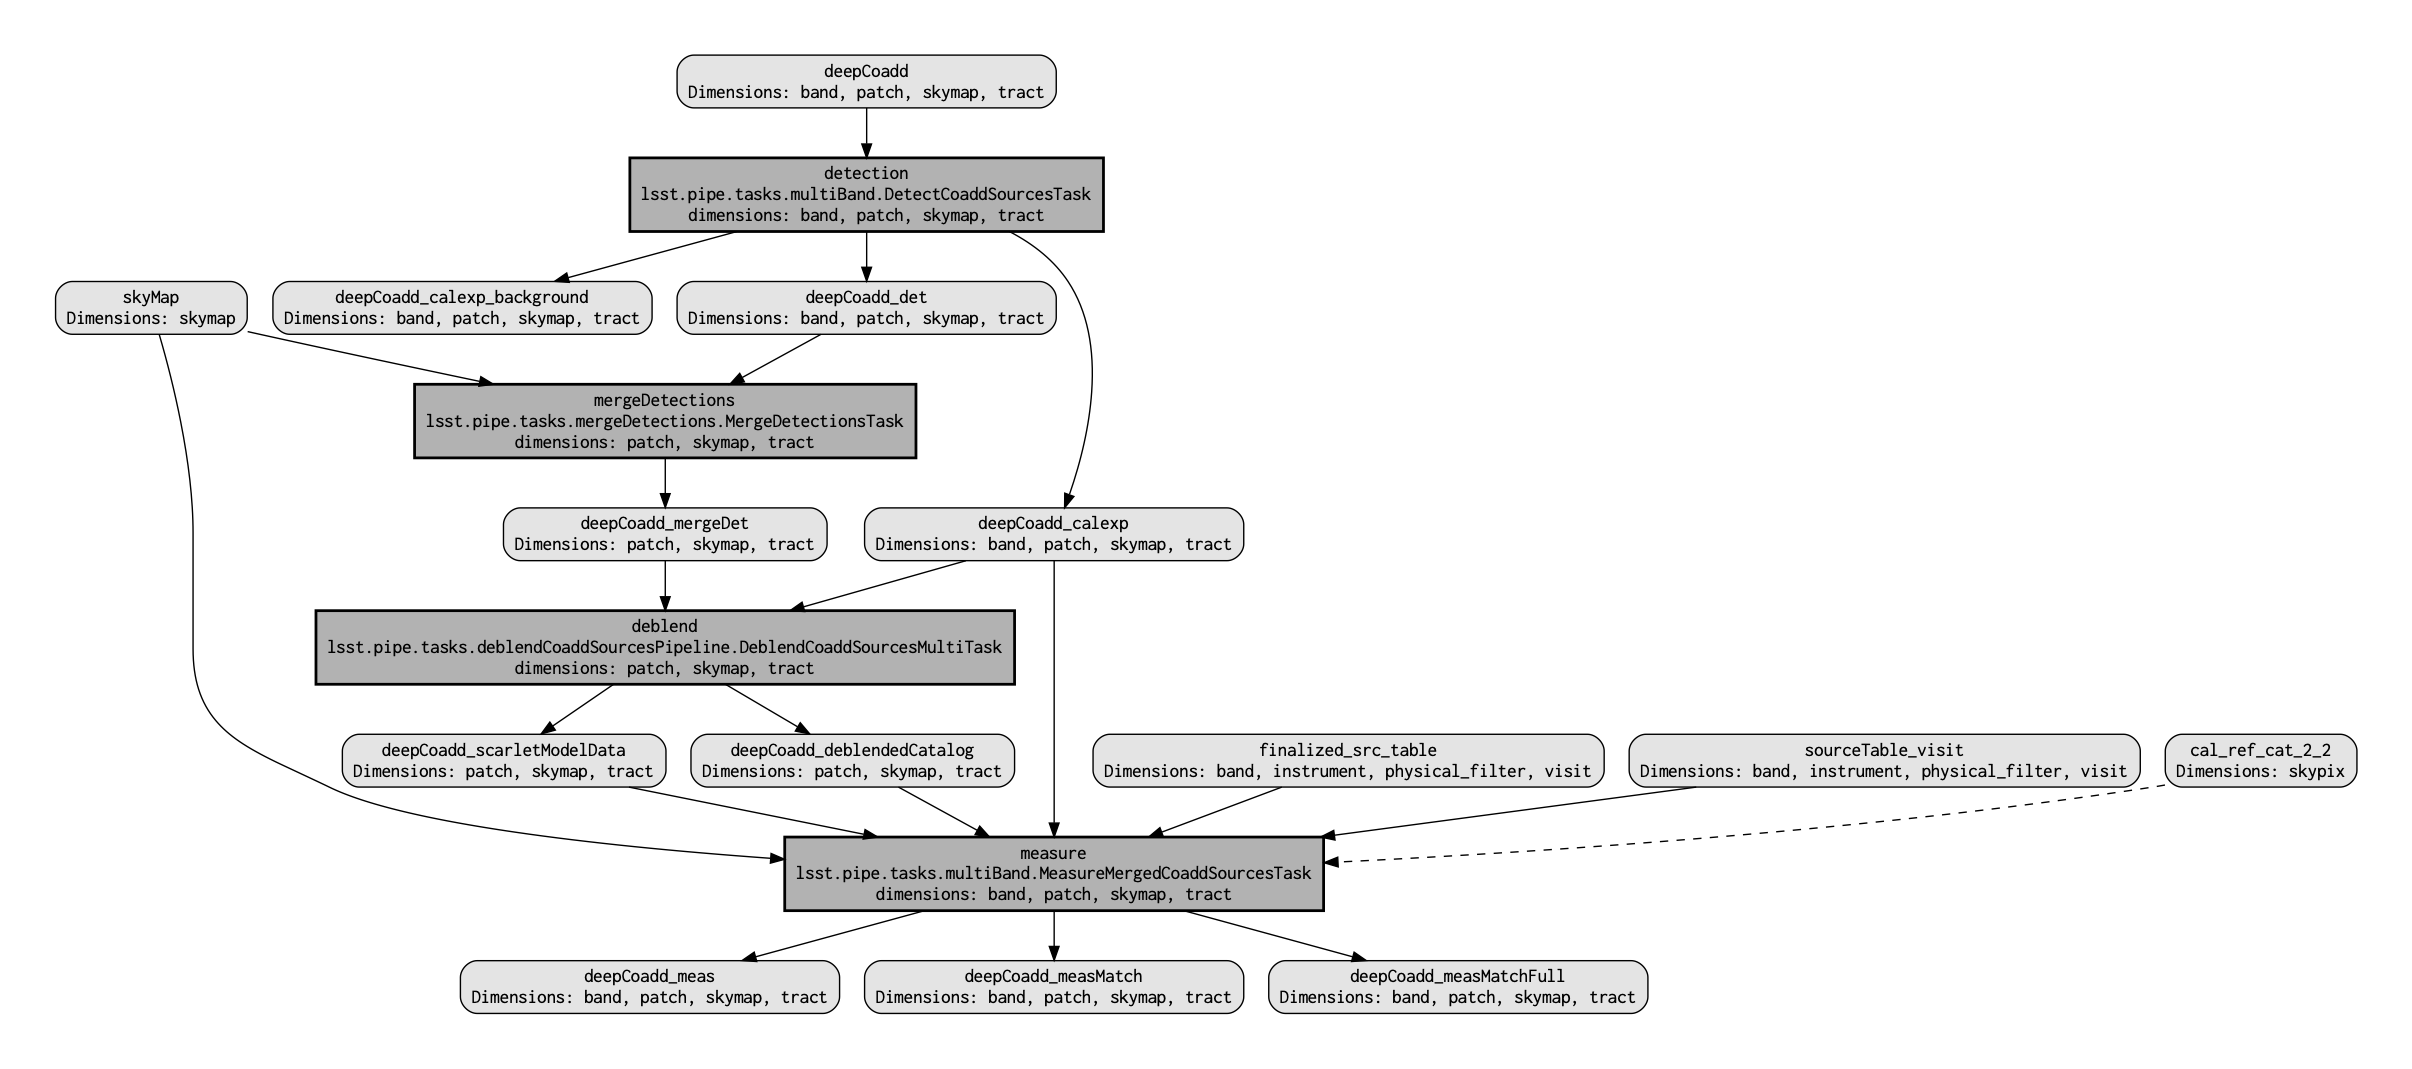

</div>

The pipeline workflow starts from the top of the `QuantumGraph`, the custom `deepCoadd`, and works its way down to the bottom, where one can see that the final output data products (light gray rectangles with rounded corners) arise from the `measure` Task

**Option:** to recreate the above `QuantumGraph` visualization, uncomment the following cell and run it. Note that running the following optional commands will create two files, `source_detection_qgraph.dot` and `source_detection_qgraph.png`, in the current user's RSP home directory. Note also that running this optional `QuantumGraph` recreation will yield a warning message which can be ignored.

In [ ]:
#from lsst.ctrl.mpexec import pipeline2dot
#pipeline2dot(sourceDetectionPipeline, '/home/' + my_username + '/source_detection_qgraph.dot')

#! dot -Tpng /home/$USER/source_detection_qgraph.dot > /home/$USER/source_detection_qgraph.png

## 2.4. Deploying the source detection pipeline

**Important**: The goal is to only run the source detection pipeline on one specific custom i-band coadd, not all of the DP0.2 `deepCoadd` products. In order to communicate this to the Simple Pipeline Executor framework, define a <a href="https://pipelines.lsst.io/modules/lsst.daf.butler/queries.html">query string</a> that specifies what dataId is to be processed. As discussed above, the desired tract (patch) to process is 4431 (17), the band is i, and the relevant sky map is that of the DC2 simulation which forms the basis of DP0.2.

In [ ]:
queryString = f"tract = 4431 AND patch = 17 AND band = 'i' AND skymap = 'DC2'"

Now it's time to define the `SimplePipelineExecutor` object that will be used to deploy source detection on the custom i-band coadd. The `SimplePipelineExecutor` brings together the URI defining the pipeline, the query string defining the data set on which to deploy source detection, and the simple butler with information about the inputs the pipeline will have to work with. These three components become the three arguments passed to the `SimplePipelineExecutor` instantiation command below.

> **Notice:** The following command returns UserWarning and FutureWarning messages that can be ignored.

In [ ]:
spe = SimplePipelineExecutor.from_pipeline(sourceDetectionPipeline, 
                                           where=queryString, 
                                           butler=simpleButler)

Run the pipeline.

There will be a lot of standard output. Alt-click to the left of the cell (or control-click for Mac) and choose "Enable Scrolling for Outputs" to condense all of the output into a scrollable inset window. There will also be a couple of warning messages which can be ignored.

In [ ]:
quanta = spe.run()

The above run of source detection, deblending, and measurement typically takes about 10-12 minutes to complete.

# 3. Analyze sources

## 3.1. Read in the custom source measurement catalog

When running the detection pipeline in Section 2, this persisted various outputs, included the final `measurement` catalogs with critical information like fluxes measured for the detected/deblended source list. Use butler to access these persisted outputs from the source detection pipeline run:

In [ ]:
butler = Butler(butler_repo, collections=[my_outputCollection])
sources = butler.get('deepCoadd_meas', dataId=my_dataId)

## 3.1. Explore the source table contents

Make the results into an astropy table for better human interaction.

First, make a copy.
Otherwise, the second cell below will fail with the error message _"Record data is not contiguous in memory."_

In [ ]:
sources = sources.copy(True)

In [ ]:
my_sources = sources.asAstropy()

**Option:** print all of the column names of source measurements.

In [ ]:
#my_sources.colnames

**Option:** explore which columns are flux measurements (not flux flags!) and which have been populated with nonzero flux values.

In [ ]:
#for col in my_sources.colnames:
#     if ((col.find('Flux') >= 0) | (col.find('flux') >= 0)) & (col.find('flag') < 0):
#         tx = np.where(my_sources[col] > 0.0)[0]
#         print(len(tx), col)
#         del tx

Convert `instFlux` to AB apparent magnitudes.

In [ ]:
my_sources.add_column('i_CalibMag_AB')
my_sources['i_CalibMag_AB'] = np.zeros(len(my_sources), dtype='float')
my_deepCoadd_photoCalib = my_deepCoadd.getPhotoCalib()
for s in range(len(my_sources)):
    my_sources['i_CalibMag_AB'][s] = \
    my_deepCoadd_photoCalib.instFluxToMagnitude(my_sources['base_CircularApertureFlux_12_0_instFlux'][s])

Restrict to only "primary" sources for subsequent detailed analysis of i-band fluxes/magnitudes. This removes e.g., parent sources and sources near the edge of the custom coadd footprint.

In [ ]:
my_sources = my_sources[my_sources['detect_isPrimary'] == True]

Plot the apparent i-band magnitude distribution of detected sources.

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(my_sources['i_CalibMag_AB'], bins=20)
plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.show()

## 3.2. Plot detected sources on a cutout of the custom coadd

Create a 1000 by 1000 pixel cutout of the custom `deepCoadd`.

In [ ]:
cutout_width = 1000
cutout_height = 1000
my_cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(my_deepCoadd.getX0(),
                                                   my_deepCoadd.getY0()),
                                 lsst.geom.Extent2I(cutout_width, cutout_height))
my_cutout = my_deepCoadd.Factory(my_deepCoadd, my_cutout_bbox)

Print the center coordinates of the cutout.

In [ ]:
bbox = my_cutout.getBBox()
wcs = my_cutout.wcs
fitsMd = wcs.getFitsMetadata()
WCSfMd = WCS(fitsMd)
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
print('Cutout center (RA, Dec): ', center)

Recall from tutorial notebook 09a that the 'science use case' adopted for context was that there was a (hypothetical) supernova at RA = 55.745834, Dec = -32.269167, and evidence of a precursor outburst during Window1 was investigated.

Convert those coordinates into a pixel location.

In [ ]:
sn_coords = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
sn_pix = wcs.skyToPixel(sn_coords)
print(sn_pix)

Display cutout with detected sources as orange circles, and the supernova location as a larger green circle.

In [ ]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.image)

afw_display.dot('o', sn_pix[0], sn_pix[1], size=20, ctype='green')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

This display shows that there is no source detected at 10-sigma (defined by `config.thresholdValue` above in Section 2.2) at the location of the (hypothetical) supernova (green circle). 

In Section 4, an exercise for the learner is to re-run source detection with a lower sigma, which would be the next analysis step for the science use-case of exploring precursor eruptions.
Recall that the DC2 simulation did not include precursor eruptions for supernovae, though -- and that there is no actual simulated supernova at the coordinates anyway. 
They are just used as an example.

In [ ]:
del bbox, wcs, fitsMd, WCSfMd, center

## 3.3. Compare with Objects in the original deepCoadd image

### 3.3.1. Make a cutout of the original deepCoadd

Instantiate a temporary butler that looks only at the DP0.2 collection.

In [ ]:
tempButler = Butler(butler_repo, collections='2.2i/runs/DP0.2')

Use the same `dataId` that defines the custom `deepCoadd`.
As a temporary butler that only looks at the DP0.2 data release collection, and not the user collection, this will retrieve the original `deepCoadd`, not the custom `deepCoadd`.

In [ ]:
deepCoadd = tempButler.get('deepCoadd', my_dataId)

Double check that this `deepCoadd` is the result of 161 input visits.

In [ ]:
deepCoadd_inputs = tempButler.get("deepCoadd.coaddInputs", my_dataId)
len(deepCoadd_inputs.visits.asAstropy())

In [ ]:
del tempButler

Create a cutout from the original `deepCoadd`.

In [ ]:
cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(deepCoadd.getX0(),
                                                deepCoadd.getY0()),
                              lsst.geom.Extent2I(cutout_width, cutout_height))
cutout = deepCoadd.Factory(deepCoadd, cutout_bbox)

**Option:** display the original `deepCoadd` cutout.

In [ ]:
#plt.figure()
#afw_display = afwDisplay.Display()
#afw_display.scale('asinh', 'zscale')
#afw_display.mtv(cutout.image)

### 3.3.2. Retrieve Objects via TAP

Use the TAP service to query and return the i-band calibrated fluxes for `Objects` detected with a signal-to-noise ratio > 10 (to match the custom coadd detection threshold set in Section 2.2) in the original `deepCoadd`, within the cutout area.

Recall that the cutout center coordinates are: 55.7572944294, -32.2945077996. Use these as the central coordinates for the TAP query.

In [ ]:
%%time
query = "SELECT objectId, coord_ra, coord_dec, detect_isPrimary, " + \
        "scisql_nanojanskyToAbMag(i_calibFlux) AS i_calibMag, " + \
        "scisql_nanojanskyToAbMagSigma(i_calibFlux, i_calibFluxErr) AS i_calibMagErr, " + \
        "i_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.757, -32.295, 0.2)) = 1 " + \
        "AND i_calibFlux/i_calibFluxErr >= 10 " + \
        "AND detect_isPrimary = 1"
tap_results = tap_service.search(query)

Store the TAP results in a pandas table.

In [ ]:
tap_table = tap_results.to_table().to_pandas()

Convert `Object` sky coordinates (RA, Dec) to `deepCoadd` pixels (x,y) and store in the TAP results table.

In [ ]:
wcs = cutout.wcs
temp1 = np.zeros(len(tap_table), dtype='float')
temp2 = np.zeros(len(tap_table), dtype='float')

for i in range(len(tap_table['coord_ra'].values)):
    sP = lsst.geom.SpherePoint(tap_table['coord_ra'][i]*lsst.geom.degrees, \
                               tap_table['coord_dec'][i]*lsst.geom.degrees)
    cpix = wcs.skyToPixel(sP)
    temp1[i] = float(cpix[0])
    temp2[i] = float(cpix[1])
    del sP, cpix

tap_table['cutout_x'] = temp1
tap_table['cutout_y'] = temp2

del wcs, temp1, temp2

### 3.3.3. Plot images side-by-side

Plot the new custom `deepCoadd` (left; 6 input visits) and original `deepCoadd` (right; 161 input visits) cutouts side-by-side.

Show newly detected sources in the custom `deepCoadd` (orange) and `Object` catalog sources from the original `deepCoadd` (red).

Making these side-by-side images can take a minute.

In [ ]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False, sharex=False)

plt.subplot(1, 2, 1)
disp1 = afwDisplay.getDisplay(frame=fig)
disp1.scale('asinh', 'zscale')
disp1.mtv(my_cutout.image)

with disp1.Buffering():
    for s in sources:
        disp1.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

plt.subplot(1, 2, 2)
disp2 = afwDisplay.getDisplay(frame=fig)
disp2.scale('asinh', 'zscale')
disp2.mtv(cutout.image)

with disp2.Buffering():
    for s in range(len(tap_table)):
        disp2.dot('o', tap_table['cutout_x'][s], tap_table['cutout_y'][s], size=10, ctype='red')

plt.show()

### 3.3.4. Compare apparent magnitudes

For sources detected in both the custom `deepCoadd` _and_ the original `deepCoadd`, plot a comparison of their apparent i-band magnitudes.

In [ ]:
plt.figure(figsize=(4, 4))

plt.plot([16, 25], [16, 25], lw=1, ls='solid', color='black')

r2d = 180.0/np.pi
idx, d2d, d3d = (SkyCoord(ra=np.array(my_sources['coord_ra'])*r2d*u.deg, 
    dec=np.array(my_sources['coord_dec'])*r2d*u.deg)).match_to_catalog_sky(
    SkyCoord(ra=tap_table['coord_ra']*u.deg, dec=tap_table['coord_dec']*u.deg))

good_match = (d2d.arcsec < 1)

plt.scatter(my_sources['i_CalibMag_AB'][good_match], tap_table['i_calibMag'][idx[good_match]],
            s=8, alpha=0.35, color='grey', marker='o', edgecolor='none', zorder=2)

plt.xlim([15, 26])
plt.ylim([15, 26])
plt.xlabel('deepCoadd i-band magnitude')
plt.ylabel('custom coadd i-band magnitude')
plt.show()

The above is only for _matched sources_.

Below, compare the apparent magnitude distributions for everything detected in the two images.

In [ ]:
plt.figure(figsize=(5, 3))

plt.hist(my_sources['i_CalibMag_AB'], bins=20, histtype='step', label='custom coadd')
plt.hist(tap_table['i_calibMag'], bins=20, histtype='step', label='original deepCoadd')

plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.legend(loc='upper left')
plt.xlim([15, 26])
plt.show()

# 4. Exercises for the learner

1. Lower the source detection threshold (e.g., from 10 to 5) and rerun the source detection and analysis. Remember to change the SNR limit in the TAP query to the `Objects` table, in order to make a meaningful comparison. 
> (Recall that the `Objects` table only includes SNR>5 detections, so if the source detection threshold for the custom `deepCoadd` is lowered to below 5, a meaningful comparison with the `Objects` table will not be possible. Rerun source detection on the original `deepCoadd` if desiring to explore low-SNR detections).
2. Compare not just the apparent magnitudes between the custom `deepCoadd` and original `deepCoadd`, but also shape parameters like PSF or the `SdssShape` moments.
3. Return to tutorial notebook 09a, create a custom `deepCoadd` for Window2, and compare it to the custom `deepCoadd` for Window1.